## 3.7 Can a network learn $\beta_i^{RD}$?

The above show comparisons between FD, RD and BP for the case where we can estimate $\beta_i^{RD}$ offline, using whatever regression methods we like. We would like to implement this estimation in an online fashion, using a simple model a neuron/network may be able to mimic.

From Section 2.3 we simulate a second network whose output will be used to approximate $\beta_i^{RD}$.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from pandas.plotting import autocorrelation_plot as autocorr
import pandas as pd

from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM, LSM_const
from lib.causal import causaleffect, causaleffect_linear

Populating the interactive namespace from numpy and matplotlib


In [2]:
q = 1
t = 10
params = ParamsLSM(q = q, p = 1, t = t)
#lsm = LSM(params)

lsm = LSM_const(params)


lib/lif.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ex = rand.choice(q, q_e, replace=False)
lib/lif.py:135: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  conn = rand.choice(q, m, replace=False)
lib/lif.py:136: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  weights = np.maximum(rand.randn(m)*sigma_w + mu_w, 0)
lib/lif.py:141: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ex = rand.choice(q, np.ceil(0.5*q), replace=False)


In [3]:
#Create two LIF neurons and train them to learn beta_i^{RD}
n = 2
params_lif = ParamsLIF()
lif = LIF(params_lif, t=t)
lif.W = np.array([3, 3])

#Choose some random weights to represent beta_i
V = rand.randn(n, q)

tau_s = 0.020
t_filter = np.linspace(0, 0.15, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

## Keeping a constant input $x$

In [4]:
(v, h, _, _) = lif.simulate()

In [5]:
v.shape

(2, 10000)

In [4]:
#Learn beta_i through 20 simulations of LIF and LSM
N = 20
x = 2
eta = .005
mu = 1
p = 0.05
alpha1 = 10
alpha2 = 30
ds = exp_filter[0]
beta_rd = np.zeros((n, N))
#V = 5*rand.randn(n, q)
V = np.ones((n,q))

#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go
c1_abv_p = np.zeros(0)
c1_abv_1 = np.zeros(0)
c1_blo_p = np.zeros(0)
c1_blo_1 = np.zeros(0)

c2_abv_p = np.zeros(0)
c2_abv_1 = np.zeros(0)
c2_blo_p = np.zeros(0)
c2_blo_1 = np.zeros(0)

beta_rd_true = np.zeros((n,N))
beta_fd_true = np.zeros((n,N))

count = 0

for idx in range(N):
    print("N=%d"%idx)
    #Simulate LSM
    s_lsm = lsm.simulate(x)
    #Simulate LIF
    (v, h, _, _) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
    s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]

    dVabv = np.zeros(V.shape)
    dVblo = np.zeros(V.shape)
    
    abvthr = np.zeros(n)
    blothr = np.zeros(n)
    
    cost = (alpha1*s1 + alpha2*s2 - x**2)**2
    dV = np.zeros(V.shape)
    bt = [False, False]
    for t in range(v.shape[1]):
        for k in range(n):
            if (v[k,t] < mu):
                if k == 0:
                    c1_blo_1 = np.hstack((c1_blo_1, cost[t]))
                else:
                    c2_blo_1 = np.hstack((c2_blo_1, cost[t]))
            if (v[k,t] >= mu):
                if k == 0:
                    c1_abv_1 = np.hstack((c1_abv_1, cost[t]))
                else:
                    c2_abv_1 = np.hstack((c2_abv_1, cost[t]))
                    
            if (v[k,t] > mu - p) & (v[k,t] < mu):
                if k == 0:
                    c1_blo_p = np.hstack((c1_blo_p, cost[t]))
                else:
                    c2_blo_p = np.hstack((c2_blo_p, cost[t]))
                blothr[k] += 1
                if bt[k] == False:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                    bt[k] = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                if k == 0:
                    c1_abv_p = np.hstack((c1_abv_p, cost[t]))
                else:
                    c2_abv_p = np.hstack((c2_abv_p, cost[t]))
                abvthr[k] += 1
                #Only do the update when firing...
                if bt[k] == True:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                    count += 1
                    V[k,:] = V[k,:] - eta*dV[k,:]*N/(N+1)
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
                    
    beta_rd_true[0,idx] = np.mean(c1_abv_p)-np.mean(c1_blo_p)
    beta_rd_true[1,idx] = np.mean(c2_abv_p)-np.mean(c2_blo_p)
    beta_fd_true[0,idx] = np.mean(c1_abv_1)-np.mean(c1_blo_1)
    beta_fd_true[1,idx] = np.mean(c2_abv_1)-np.mean(c2_blo_1)

    s_lsm = lsm.simulate(x)
    beta_rd[:,idx] = np.mean(np.dot(V, s_lsm[:,-100:]),1)

#Test how well we learnt beta through an extra second of simulation
print("N = %d. Unit 1. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[0], blothr[0], 100*float(abvthr[0])/(blothr[0]+abvthr[0])))
print("N = %d. Unit 2. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[1], blothr[1], 100*float(abvthr[1])/(blothr[1]+abvthr[1])))


N=0
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
N=11
N=12
N=13
N=14
N=15
N=16
N=17
N=18
N=19
N = 19. Unit 1. Above thr 70: Below thr: 138. Percent above: 33.65
N = 19. Unit 2. Above thr 71: Below thr: 136. Percent above: 34.30


array([[-2.16097332],
       [-4.49446795]])

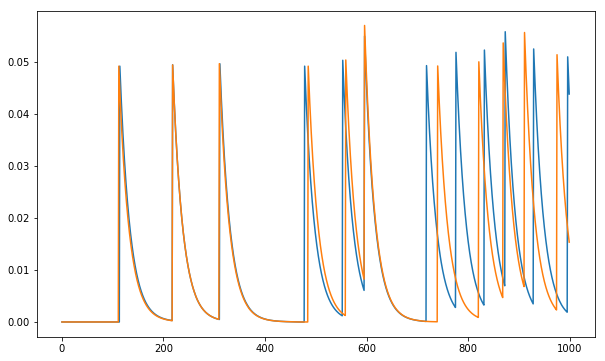

In [5]:
plt.plot(s1[0:1000])
plt.plot(s2[0:1000], 'C1')
c1_blo_1.shape
V
#plt.plot(cost)

0.049115557975038311

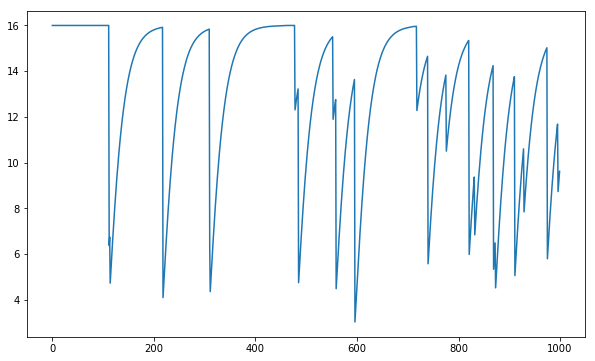

In [6]:
plt.plot(cost[0:1000])
ds

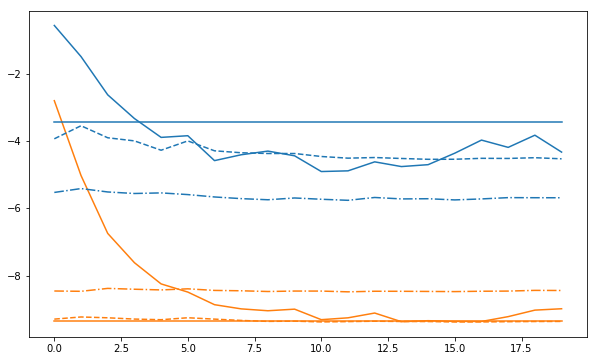

In [7]:
beta_bp1 = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2)*ds-2*alpha1*(x**2)*ds
beta_bp2 = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1)*ds-2*alpha2*(x**2)*ds
        
#Plot the learning progress
plt.plot(range(N), 2*beta_rd[0,:], range(N), 2*beta_rd[1,:]);
plt.plot(range(N), beta_bp1*np.ones(N), 'C0', range(N), beta_bp2*np.ones(N), 'C1');
plt.plot(range(N), beta_rd_true[0,:], '--C0', range(N), beta_rd_true[1,:], '--C1');
plt.plot(range(N), beta_fd_true[0,:], '-.C0', range(N), beta_fd_true[1,:], '-.C1');

From which we see the weights for both units learn the right values. The dot-dashed lines are the FD estimator, the dashed line is the RD estimator, and the solid curve is the learned weights through SGD -- they should approximate the RD estimator. The solid and flat curves are the 'true' BP gradient.

## Does learning a linear model improve the results?

We can also estimate parameters of a linear model for which to estimate $\beta$. How should this work?

## How many units in the LSM can be used?

Let's see the stability when the number of units is increased.

q = 10

In [22]:
q = 100
t = 10
params = ParamsLSM(q = q, p = 1, t = t)
lsm = LSM(params)

n = 2
params_lif = ParamsLIF()
lif = LIF(params_lif, t=t)
lif.W = np.array([5, 5])

V = rand.randn(n, q)
tau_s = 0.020
t_filter = np.linspace(0, 0.15, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#Learn beta_i through 20 simulations of LIF and LSM
N = 20
x = 2
eta = .5
mu = 1
p = 0.05
alpha1 = 0
alpha2 = 30
ds = exp_filter[0]
beta_rd = np.zeros((n, N))
#V = 5*rand.randn(n, q)
V = np.ones((n,q))

#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go
c1_abv_p = np.zeros(0)
c1_abv_1 = np.zeros(0)
c1_blo_p = np.zeros(0)
c1_blo_1 = np.zeros(0)

c2_abv_p = np.zeros(0)
c2_abv_1 = np.zeros(0)
c2_blo_p = np.zeros(0)
c2_blo_1 = np.zeros(0)

beta_rd_true = np.zeros((n,N))
beta_fd_true = np.zeros((n,N))

count = 0

for idx in range(N):
    print("N=%d"%idx)
    #Simulate LSM
    s_lsm = lsm.simulate(x)
    #Simulate LIF
    (v, h, _, _) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
    s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]

    dVabv = np.zeros(V.shape)
    dVblo = np.zeros(V.shape)
    
    abvthr = np.zeros(n)
    blothr = np.zeros(n)
    
    cost = (alpha1*s1 + alpha2*s2 - x**2)**2
    dV = np.zeros(V.shape)
    bt = [False, False]
    for t in range(v.shape[1]):
        for k in range(n):
            if (v[k,t] < mu):
                if k == 0:
                    c1_blo_1 = np.hstack((c1_blo_1, cost[t]))
                else:
                    c2_blo_1 = np.hstack((c2_blo_1, cost[t]))
            if (v[k,t] >= mu):
                if k == 0:
                    c1_abv_1 = np.hstack((c1_abv_1, cost[t]))
                else:
                    c2_abv_1 = np.hstack((c2_abv_1, cost[t]))
                    
            if (v[k,t] > mu - p) & (v[k,t] < mu):
                if k == 0:
                    c1_blo_p = np.hstack((c1_blo_p, cost[t]))
                else:
                    c2_blo_p = np.hstack((c2_blo_p, cost[t]))
                blothr[k] += 1
                if bt[k] == False:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                    bt[k] = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                if k == 0:
                    c1_abv_p = np.hstack((c1_abv_p, cost[t]))
                else:
                    c2_abv_p = np.hstack((c2_abv_p, cost[t]))
                abvthr[k] += 1
                #Only do the update when firing...
                if bt[k] == True:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                    count += 1
                    V[k,:] = V[k,:] - eta*dV[k,:]#*N/(N+1)
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
                    
    beta_rd_true[0,idx] = np.mean(c1_abv_p)-np.mean(c1_blo_p)
    beta_rd_true[1,idx] = np.mean(c2_abv_p)-np.mean(c2_blo_p)
    beta_fd_true[0,idx] = np.mean(c1_abv_1)-np.mean(c1_blo_1)
    beta_fd_true[1,idx] = np.mean(c2_abv_1)-np.mean(c2_blo_1)

    s_lsm = lsm.simulate(x)
    beta_rd[:,idx] = np.mean(np.dot(V, s_lsm[:,-100:]),1)


N=0
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
N=11
N=12
N=13
N=14
N=15
N=16
N=17
N=18
N=19


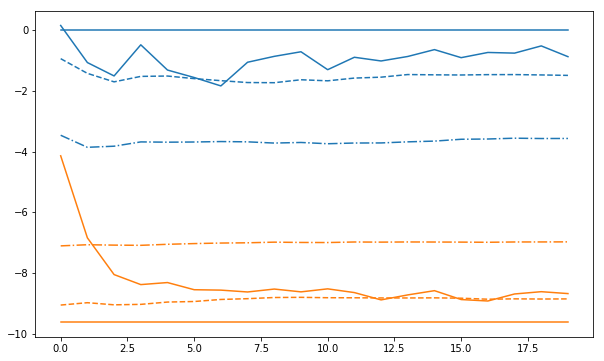

In [23]:
beta_bp1 = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2)*ds-2*alpha1*(x**2)*ds
beta_bp2 = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1)*ds-2*alpha2*(x**2)*ds
        
#Plot the learning progress
plt.plot(range(N), 2*beta_rd[0,:], range(N), 2*beta_rd[1,:]);
plt.plot(range(N), beta_bp1*np.ones(N), 'C0', range(N), beta_bp2*np.ones(N), 'C1');
plt.plot(range(N), beta_rd_true[0,:], '--C0', range(N), beta_rd_true[1,:], '--C1');
plt.plot(range(N), beta_fd_true[0,:], '-.C0', range(N), beta_fd_true[1,:], '-.C1');

Thus the LSM learns the cost gradient after only a few 'epochs'. Shown here is the output with highly correlated input, in which the RD estimator is able to distinguish its effect on the cost from its neighbor.

## Performance over a range of weights $W$

See fig_4_learning_beta workbook

## Learning beta over a range of inputs $x$

First we have to determine what a good cost function to test all this on is. We can simulate some networks over weights and over a distribution of inputs $x$. From this we can produce a cost function landscape, finding the right parameterizations to then rerun the simulation with the learning rule on top. The learning rule requires the cost function, so these simulations must already have its parameters determined, we can't run simulations and then determine the right parameters in the analysis post facto.

In [ ]:
#Learn beta_i through 20 simulations of LIF and LSM
N = 200
t = 1
x = 2
eta = .005
mu = 1
p = 0.05
alpha1 = 10
alpha2 = 30
ds = exp_filter[0]
beta_rd = np.zeros((n, N))
V = np.ones((n,q))

count = 0

#Load the precomputed sims from